In [1]:
import gym
import random
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from collections import deque
print("Gym:", gym.__version__)
print("Tensorflow:", tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
Gym: 0.17.1
Tensorflow: 2.1.0


In [2]:
#Q network é um algoritmo de aprendizado de máquina do tipo reinforcement learning no qual um agente é 
#treinado através de uma função de recompensa para chegar ao resultado desejado
#no caso da Q network essa função é Q(St,At) = r(t+1) + D*max(Q(S(t+1)))
#no qual r(t+1) é a recompensa calculada pelo algoritmo para a próxima ação At no estado St
#D é o discount rate, para tomar em consideração a incerteza da recompensa dos cálculos posteriores 
#ao seguinte passo

class QNetwork():
    def __init__(self, state_dim, action_size, tau=0.01):
        tf.reset_default_graph() #como os nomes das variáveis estão sendo separadas em local e target é boa prática resetar o tensorflow depois cada iteração
        self.state_in = tf.placeholder(tf.float32, shape=[None, *state_dim]) #parametros de inicialização da classe
        self.action_in = tf.placeholder(tf.int32, shape=[None]) #placeholder para as variáveis que vâo ser alimentadas por valores
        self.q_target_in = tf.placeholder(tf.float32, shape=[None]) #são os inputs da rede neural
        self.importance_in = tf.placeholder(tf.float32, shape=[None])
        action_one_hot = tf.one_hot(self.action_in, depth=action_size)
        
        self.q_state_local = self.build_model(action_size, "local") #cria a versão local da nossa Q network
        self.q_state_target = self.build_model(action_size, "target") #cria a versão target da nossa Q nextwor
        
        self.q_state_action = tf.reduce_sum(tf.multiply(self.q_state_local, action_one_hot), axis=1)#faz a multiplicação dos elementos do atual estado da função Q e da próxima melhor ação possível em um só eixo/vetor para receber o valor da nossa ação e retorna como uma dimensão graças ao reduce_sum()
        self.error = self.q_state_action - self.q_target_in #define o erro da operação, o erro é a recompensa gerada por uma ação menos a recompensa que deveria ter sido gerada pela ação de acordo com a nossa função
        self.loss = tf.reduce_mean(tf.multiply(tf.square(self.error), self.importance_in)) #a perca do algoritmo é igual a multiplcação do quadrado do erro com 
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
        
        self.local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="local") #separa as variáveis local
        self.target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="target") #separa as variaveis target
        self.updater = tf.group([tf.assign(t, t + tau*(l-t)) for t,l in zip(self.target_vars, self.local_vars)]) #operação de atualização das variáveis na rede target, assign() permite colocar um novo valor de uma variável para cada seção
        
    def build_model(self, action_size, scope):
        with tf.variable_scope(scope):#permite a criação de novas variáveis e valida que essas novas variáveis estão no gráfico default
            hidden1 = tf.layers.dense(self.state_in, 100, activation=tf.nn.relu)
            q_state = tf.layers.dense(hidden1, action_size, activation=None)
            return q_state
        
    def update_model(self, session, state, action, q_target, importance):
        feed = {self.state_in: state, self.action_in: action, self.q_target_in: q_target, self.importance_in: importance}
        error, _, _ = session.run([self.error, self.optimizer, self.updater], feed_dict=feed)
        return error
        
    def get_q_state(self, session, state, use_target=False):
        q_state_op = self.q_state_target if use_target else self.q_state_local
        q_state = session.run(q_state_op, feed_dict={self.state_in: state})
        return q_state

In [3]:
#o replaybuffer é uma "função" que usa todos os "steps" e faz um sample deles para ter uma ideia melhor da recompensa da próxima ação
#sem o replaybuffer o nosso algoritmo pode ficar muito viçado nas experiências que ocorrem comumente 
#e não usarem experiências mais raras, diminuindo a capacidade do algoritmo de fazer ações exploratórias
class PrioritizedReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        self.priorities = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))
        
    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities
    
    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance / max(importance)
        return importance_normalized
        
    def sample(self, batch_size, priority_scale=1.0):
        sample_size = min(len(self.buffer), batch_size)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k=sample_size, weights=sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return map(list, zip(*samples)), importance, sample_indices
    
    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

In [4]:
#Uma double q network passa a ação por duas redes neurais para ter uma aproximação da recompensa do próximo passo(next action taken) mais precisa
#uma Q network será a rede local e a outra será a target network, a local reflete onde o nosso algoritmo está nesse momento e a target reflete o valor que ela deveria estar no msm momento
class DoubleDQNAgent():
    def __init__(self, env):
        self.state_dim = env.observation_space.shape
        self.action_size = env.action_space.n
        self.q_network = QNetwork(self.state_dim, self.action_size)
        self.replay_buffer = PrioritizedReplayBuffer(maxlen=100000) #permite usar um vetor de comprimento 100000, no qual a experiência do algoritmo está em cada elemento do mais velho pro mais novo, a função deque joga fora as informações mais velhas quando o vetor estiver cheio
        self.gamma = 0.97
        self.eps = 1.0 #variável que corresponde à probabilidade do algoritmo escolher uma ação exploratória(ação que pode gerar maior recompensa no futuro, após N+1 espaços de estado) ao invés de uma ação gananciosa(a que irá gerar a maior recompensa possível no próxmo passo)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def get_action(self, state):
        q_state = self.q_network.get_q_state(self.sess, [state])
        action_greedy = np.argmax(q_state)#retorna os máximos valores de recompensa da função Q para ter a greedy action
        action_random = np.random.randint(self.action_size) #ação aleatória
        action = action_random if random.random() < self.eps else action_greedy #define a probabilidade de selecionar a ação greedy/aleatória baseado no valor de epsilon
        return action
    
    def get_env_action(self, action):
        return action
    
    def train(self, state, action, next_state, reward, done, use_DDQN=True, a=0.0): #função que irá treinar os novos valores de Q, puxando esses valores para o nosso replaybuffer
        self.replay_buffer.add((state, action, next_state, reward, done))
        (states, actions, next_states, rewards, dones), importance, indices = self.replay_buffer.sample(50, priority_scale=a)
        
        next_actions = np.argmax(self.q_network.get_q_state(self.sess, next_states, use_target=False), axis=1)
        q_next_states = self.q_network.get_q_state(self.sess, next_states, use_target=use_DDQN)
        q_next_states[dones] = np.zeros([self.action_size]) #enche a matriz dos proximos estados de zero conforme o action_size
        q_next_states_next_actions = q_next_states[np.arange(next_actions.shape[0]), next_actions]
        q_targets = rewards + self.gamma * q_next_states_next_actions #função Q, isso é Q = r(t)+D*Q(S(t+1))
        errors = self.q_network.update_model(self.sess, states, actions, q_targets, importance**(1-self.eps))
        
        self.replay_buffer.set_priorities(indices, errors)
        
        if done: self.eps = max(0.1, 0.98*self.eps)
    
    def __del__(self): #é o "destructor", sempre que inicializamos uma sessão no tensorflow é recomendado fechar essa sessão quando pararmos de utilizá-lo
        self.sess.close()

In [5]:
#discretiza o tipo de ação do agente para utilizar ambientes que usam espaços contínuos
#se a ação do ambiente n for discreta ele não faz nada
class DiscretizedDQNAgent(DoubleDQNAgent):
    def __init__(self, env, n_actions=10):
        self.is_discrete = type(env.action_space) == gym.spaces.discrete.Discrete #se for discreto retorna como uma espaço de estados discreto
        if not self.is_discrete:
            env.action_space.n = n_actions #se n for discreto retorna as ações em espaços de estados e o numpy.linspace() coloca uma posição para cada ação
            self.actions = np.linspace(env.action_space.low, env.action_space.high, n_actions)
        super().__init__(env)
        
    def get_env_action(self, action):
        if not self.is_discrete:
            action = [self.actions[action]]
        return action

In [6]:
from gym import wrappers
from time import time
env_names = ["CartPole-v0",
             "MountainCar-v0",
             "MountainCarContinuous-v0",
             "Pendulum-v0",
             "Acrobot-v1",
             "InvertedDoublePendulum-v2"]
env = gym.make(env_names[5])
env = wrappers.Monitor(env, './videos/' + str(time()) + '/')
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box(11,)
Action space: Box(1,)


In [7]:
#sistema de treino do agente e calculo da recompensa
num_runs = 1
run_rewards = []

for n in range(num_runs):
    print("Run {}".format(n))
    ep_rewards = []
    agent = None
    agent = DiscretizedDQNAgent(env)
    num_episodes = 400

    for ep in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(agent.get_env_action(action))
            agent.train(state, action, next_state, reward, done, a=0.7)
            env.render()
            total_reward += reward
            state = next_state

        ep_rewards.append(total_reward)
        print("Episode: {}, total_reward: {:.2f}".format(ep, total_reward))
        
    run_rewards.append(ep_rewards)

Run 0
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Creating window glfw
Episode: 0, total_reward: 54.13
Episode: 1, total_reward: 54.77
Episode: 2, total_reward: 35.68
Episode: 3, total_reward: 63.70
Episode: 4, total_reward: 36.23
Episode: 5, total_reward: 53.91
Episode: 6, total_reward: 101.04
Episode: 7, total_reward: 36.13
Episode: 8, total_reward: 54.08
Episode: 9, total_reward: 73.36
Episode: 10, total_reward: 45.47
Episode: 11, total_reward: 44.92
Episode: 12, total_reward: 36.22
Episode: 13, total_reward: 44.90
Episode: 14, total_reward: 45.07
Episode: 15, total_reward: 44.85
Episode: 16, total_reward: 54.41
Episode: 17, total_reward: 54.50
Episode: 18, total_reward: 36.23
Episode: 19, total_reward: 54.48
Episode: 20, total_reward: 35.97
Episode: 21, total_reward: 54.85
Episode: 22, total_reward: 73.13
Episode: 23, total_reward: 45.63
Episode: 24, total_reward: 82.47
Episode: 25, total_reward: 

Episode: 229, total_reward: 44.78
Episode: 230, total_reward: 54.44
Episode: 231, total_reward: 73.23
Episode: 232, total_reward: 91.88
Episode: 233, total_reward: 129.57
Episode: 234, total_reward: 91.60
Episode: 235, total_reward: 119.94
Episode: 236, total_reward: 82.58
Episode: 237, total_reward: 91.80
Episode: 238, total_reward: 101.41
Episode: 239, total_reward: 82.78
Episode: 240, total_reward: 83.06
Episode: 241, total_reward: 128.75
Episode: 242, total_reward: 82.23
Episode: 243, total_reward: 82.41
Episode: 244, total_reward: 139.00
Episode: 245, total_reward: 82.58
Episode: 246, total_reward: 82.76
Episode: 247, total_reward: 82.95
Episode: 248, total_reward: 101.44
Episode: 249, total_reward: 82.29
Episode: 250, total_reward: 54.70
Episode: 251, total_reward: 92.01
Episode: 252, total_reward: 109.70
Episode: 253, total_reward: 73.64
Episode: 254, total_reward: 73.21
Episode: 255, total_reward: 91.76
Episode: 256, total_reward: 119.40
Episode: 257, total_reward: 91.69
Episod

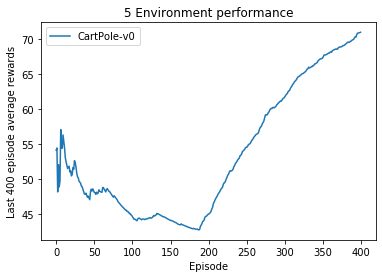

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

for n, ep_rewards in enumerate(run_rewards):
    x = range(len(ep_rewards))
    cumsum = np.cumsum(ep_rewards) #soma cumulativa das recompensas de cada treino
    avgs = [cumsum[ep]/(ep+1) if ep<400 else (cumsum[ep]-cumsum[ep-400])/400 for ep in x]
    plt.plot(x, avgs, label=env_names[n])
    
plt.title("5 Environment performance")
plt.xlabel("Episode")
plt.ylabel("Last 400 episode average rewards")
plt.legend()